In [19]:
import xarray as xr
import intake
from collections import defaultdict
import matplotlib.pyplot as plt
import xesmf as xe
import numpy as np
import cartopy.crs as ccrs
import xesmf

In [20]:
path_1dgr = "lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5/ERA5_monthly.1940-2025.precip_radflx.1deg.nc"
#path_2dgr = "lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5/ERA5_monthly.1940-2025.precip_radflx.2deg.nc"
data_1dgr = xr.open_dataset(path_1dgr, chunks = "auto")
#data_2dgr = xr.open_dataset(path_2dgr, chunks = "auto")

#data_1dgr.variables

precipitation_data_ERA5 =  data_1dgr['tp']
precipitation_data_ERA5



<xarray.DataArray 'tp' (valid_time: 1029, lat: 180, lon: 360)> Size: 267MB
dask.array<open_dataset-tp, shape=(1029, 180, 360), dtype=float32, chunksize=(818, 143, 286), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2025-...
  * lon         (lon) float64 3kB 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * lat         (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes: (12/32)
    standard_name:                            unknown
    long_name:                                Total precipitation
    units:                                    m
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    ...                                       ...
    GRIB_missingValue:                        3.4028234663852886e+38
    GRIB_name:                                Total precipitation
    GRIB_shortName:                           tp
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    GRIB_surface:                             0.0

(180, 360)


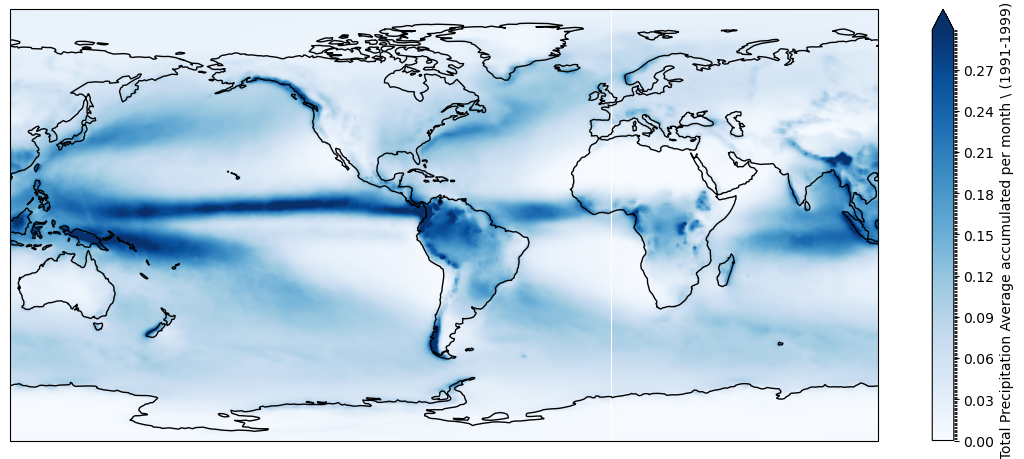

In [21]:

area_prec = precipitation_data_ERA5.sel(valid_time=slice("1990","1999"))

#area_prec = area_prec.mean(dim="valid_time") 

days = area_prec["valid_time"].dt.days_in_month

# Mittelwert der Tagesmenge (falls tp ~ m/day)
tp_day_mean = area_prec.weighted(days).mean("valid_time")  # gewichtet nach Monatslänge

# dann in Monatssumme eines "durchschnittlichen" Monats umrechnen:
mean_days = days.mean().item()
area_prec = tp_day_mean * mean_days


print(area_prec.values.shape)
plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=290))
area_prec.plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='Blues', 
    levels=np.arange(0, 0.3, 0.001), # Anomalie-Skala
    cbar_kwargs={'label': f'Daily Total Precipitation Average accumulated per month \\ (1991-1999) [m]', "shrink":0.7}
                 #'orientation': 'vertical',"shrink" : 0.7,
                 #'pad': 0.05}
)
ax.coastlines()
#ax.set_global()
#ax.set_title(f'Relative Temperature anomaly of 2024 to (1991-2020) |  mean anomaly: {global_anomaly_value_2024:.3f} °C')
plt.show()

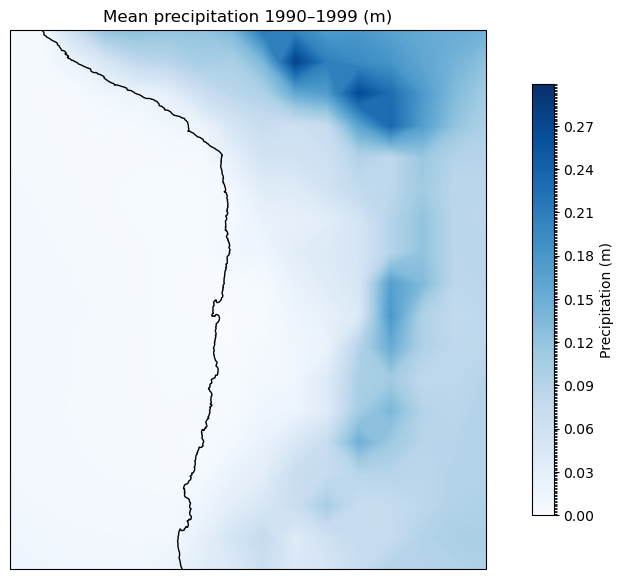

In [22]:
andes = [-32, -14, 360-78+0.5, 360-62+0.5]
area_prec2= area_prec.sel(lat=slice(-32, -14), lon = slice(360-78+0.5, 360-62+0.5)) #lat=slice(-40.5, 30.5), lon = slice(280,320)
area_prec2
plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())   # Daten sind in PlateCarree
im = area_prec2.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap="Blues",                               # sequentiell statt divergend
    levels=np.arange(0, 0.3, 0.001),
    cbar_kwargs={"label": "Precipitation (m)", "shrink": 0.8},
)
ax.coastlines()
#ax.set_extent([280, 340, -30, 0], crs=ccrs.PlateCarree())  # zoom auf Box
ax.set_title("Mean precipitation 1990–1999 (m)")
plt.show()

In [23]:
cat = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
query = dict(
    variable_id=['pr'],
    table_id='Amon',
    experiment_id=['historical'],
    grid_label='gn',
    member_id='r1i1p1f1'
)

cat_subset = cat.search(require_all_on=["source_id"], **query)

dsets = cat_subset.to_dataset_dict(
    zarr_kwargs={'consolidated': True},
    storage_options={'token': 'anon'}
)

for model_name, ds in dsets.items():
    print(f"Model: {model_name}, Dataset dimensions: {ds.dims}")
print(f'Anzahl Modelle vor Löschung: {len(dsets)}')
key = ""
for model_name, ds in dsets.items():
    if "i" in ds.dims:
        key = model_name
        print(f"Model mit falschen Dimensionen und wird gelöscht: {model_name}, Dims: {ds.dims}")
del dsets[key]

print(f'Anzahl Modelle nach Löschung: {len(dsets)}')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Model: CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn, Dataset dimensions: FrozenMappingWarningOnValuesAccess({'lat': 96, 'bnds': 2, 'lon': 192, 'member_id': 1, 'dcpp_init_year': 1, 'time': 1980})
Model: CMIP.AS-RCEC.TaiESM1.historical.Amon.gn, Dataset dimensions: FrozenMappingWarningOnValuesAccess({'lat': 192, 'bnds': 2, 'lon': 288, 'member_id': 1, 'dcpp_init_year': 1, 'time': 1980})
Model: CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn, Dataset dimensions: FrozenMappingWarningOnValuesAccess({'lat': 192, 'bnds': 2, 'lon': 288, 'member_id': 1, 'dcpp_init_year': 1, 'time': 1980})
Model: CMIP.NASA-GISS.GISS-E2-2-H.historical.Amon.gn, Dataset dimensions: FrozenMappingWarningOnValuesAccess({'lat': 90, 'bnds': 2, 'lon': 144, 'member_id': 1, 'dcpp_init_year': 1, 'time': 1980})
Model: CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn, Dataset dimensions: FrozenMappingWarningOnValuesAccess({'lat': 90, 'bnds': 2, 'lon': 144, 'member_id': 1, 'dcpp_init_year': 1, 'time': 1980})
Model: CMIP.NCC.NorESM2-MM.

Model: CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn <xarray.DataArray (lat: 96, lon: 192)> Size: 147kB
dask.array<getitem, shape=(96, 192), dtype=float64, chunksize=(96, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 768B -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1


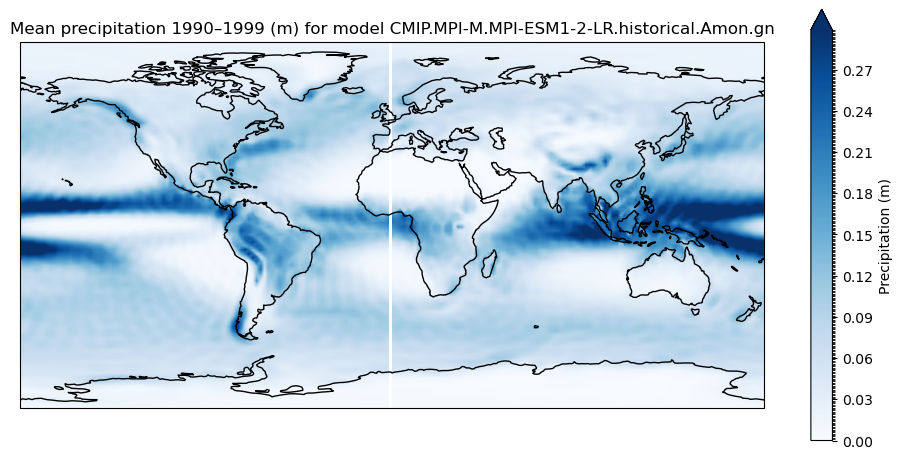

In [24]:
pr_means = {}

for model_name, ds in dsets.items():
    #ds = model
    """pr = ds['pr']
    pr_mean = pr.sel(time=slice("1990","1999")).mean(dim="time")
    sec_per_month_mean = (pr["time"].dt.days_in_month * 86400).mean().item()
    pr_m_month = pr_mean * sec_per_month_mean / 1000  # m/Monat
    pr_means[model_name] = pr_mean"""
    pr = ds["pr"].sel(time=slice("1990", "1999"))  # kg m-2 s-1

    # Sekunden pro Monat (für jedes time-Element individuell!)
    sec_per_month = xr.DataArray(
        pr["time"].dt.days_in_month.astype("int64") * 86400,
        coords={"time": pr["time"]},
        dims="time"
    )

    # Monatsmenge in m/Monat: (kg m-2 s-1) * (s/Monat) = kg m-2 = mm; dann /1000 -> m
    pr_m_month_ts = (pr * sec_per_month) / 1000

    # Mittel über 1990–1999 und Singleton-Dims entfernen
    pr_m_month_mean = pr_m_month_ts.mean("time").squeeze(drop=True)

    pr_means[model_name] = pr_m_month_mean   # <-- WICHTIG: das konvertierte Feld speichern!


key1 = list(pr_means.keys())[0]
#print('test',pr_means[key1])
test = pr_means[key1]
print(f'Model: {key1}', test)


plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())   # Daten sind in PlateCarree
im = test.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap="Blues",                               # sequentiell statt divergend
    levels=np.arange(0, 0.3, 0.001),
    cbar_kwargs={"label": "Precipitation (m)", "shrink": 0.8},
)
ax.coastlines()
ax.set_title(f"Mean precipitation 1990–1999 (m) for model {key1}")
plt.show()

In [25]:

for index, ds in enumerate(dsets.items()):
    key = list(pr_means.keys())[index]
    #print('test',pr_means[key1])
    test = pr_means[key]
    testdata = dsets[key]
    testdata = testdata.sel(time=slice("1990","1999"))
    #print(len(testdata['time']))

testdata = dsets[key1]
testdata

<xarray.Dataset> Size: 146MB
Dimensions:         (lat: 96, bnds: 2, lon: 192, member_id: 1,
                     dcpp_init_year: 1, time: 1980)
Coordinates:
  * lat             (lat) float64 768B -88.57 -86.72 -84.86 ... 86.72 88.57
    lat_bnds        (lat, bnds) float64 2kB dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon             (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    lon_bnds        (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-1...
    time_bnds       (time, bnds) datetime64[ns] 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    pr              (member_id, dcpp_init_year, time, lat, lon) float32 146MB dask.array<chunksize=(1, 1, 904, 96, 192), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:variable_id:     pr
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-...
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amo...

In [26]:
"""for name, ds in dsets.items():
    unit = ds['pr'].attrs['units']
    print(f'Model: {name}, unit of pr: {unit}')
    
for name, ds in dsets.items():
    frequency = ds.attrs['frequency']
    print(f'Model: {name}, frequency of pr: {frequency}')
"""
index = 0
for name, ds in dsets.items():
    if 'lon' in ds.coords:
        lons = ds['lon'].values
        print("Lon: max =", lons.max())
        #print(f'Model: {name} =  Latitude')
        index += 1
    if 'longitude' in ds.coords:
        longs = ds['longitude'].values
        print("Longitude: max =", longs.max())
        #print(f'Model: {name} =  Latitude')
        index += 1
print("Anzahl der Modelle:", index)

Lon: max = 358.125
Lon: max = 358.75
Lon: max = 358.75
Lon: max = 358.75
Lon: max = 358.75
Lon: max = 358.75
Lon: max = 357.1875
Longitude: max = 356.25
Lon: max = 358.59375
Lon: max = 357.5
Lon: max = 358.0
Lon: max = 358.875
Lon: max = 359.0625
Lon: max = 357.5
Lon: max = 358.125
Lon: max = 358.75
Lon: max = 358.875
Lon: max = 358.59375
Lon: max = 358.125
Lon: max = 357.5
Lon: max = 358.75
Lon: max = 358.75
Lon: max = 357.5
Lon: max = 358.125
Lon: max = 359.0625
Lon: max = 358.75
Lon: max = 358.75
Lon: max = 359.0625
Lon: max = 358.125
Lon: max = 357.1875
Lon: max = 358.75
Lon: max = 358.75
Lon: max = 358.125
Lon: max = 358.75
Lon: max = 358.875
Anzahl der Modelle: 35


Frequency (monthly) und Einheiten sind identisch. Aber nciht alle Modelle haben 'lon' sondern ein paar auch 'longitude' => renamen 
Longituden und Latituden haben beide denselben Typ (0, 359 für Long und -90, 90 für Lats) => Nur Renamen bleibt übrig

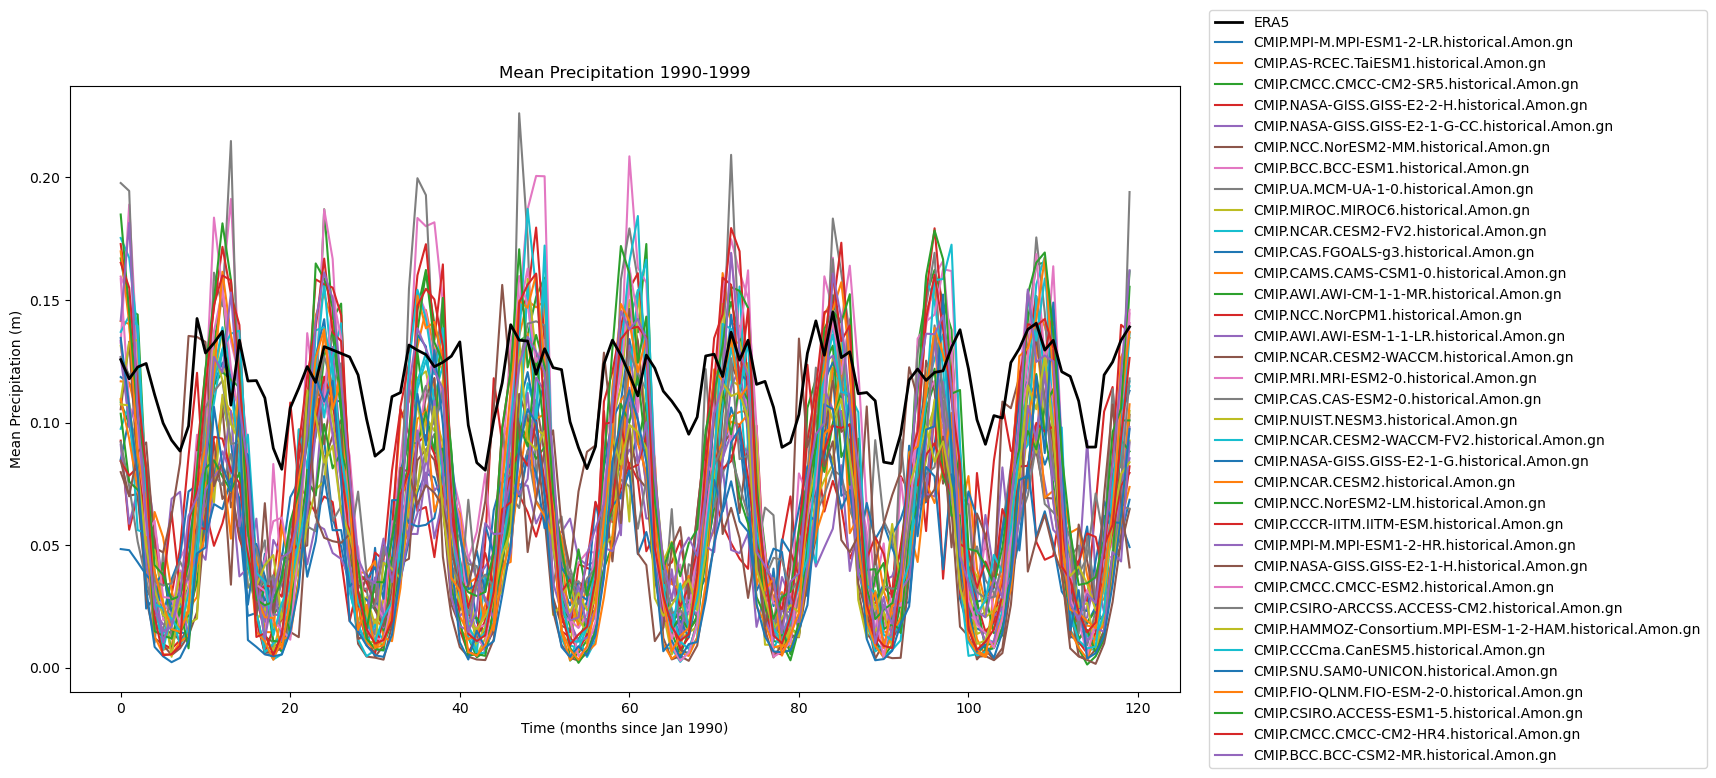

In [27]:
plt.figure(figsize=(12, 7))
andes = [-32, -14, 360-78+0.5, 360-62+0.5]
ERA5_plot =precipitation_data_ERA5.sel(valid_time=slice("1990","1999"), lat=slice(-40.5, 30.5), lon=slice(280,320))
tp_mmonth = ERA5_plot * ERA5_plot["valid_time"].dt.days_in_month

era5_mean_ts = tp_mmonth.mean(dim=("lat","lon"))

# ein einziger mittlerer Monatswert über 1990–1999
era5_mean = era5_mean_ts.mean("valid_time")
plt.plot(np.arange(era5_mean_ts.size), era5_mean_ts, label="ERA5", color ="black", linewidth=2, zorder=10)
plt.ylabel('Mean Precipitation (m)')
plt.xlabel('Time (months since Jan 1990)')
plt.title('Mean Precipitation 1990-1999')
plt.tight_layout()
for name, ds in dsets.items():
    if "longitude" in ds.coords:
        ds = ds.rename({"longitude": "lon"})
    if "latitude" in ds.coords:
        ds = ds.rename({"latitude": "lat"})
    try:
        ds = ds.sel(lat=slice(-32, -14), lon = slice(360-78+0.5, 360-62+0.5))
        time = ds['time'].sel(time=slice("1990","1999")).values
        pr = ds['pr'].sel(time=slice("1990","1999"))
        sec_per_month = pr["time"].dt.days_in_month * 86400
        pr_m_month = (pr * sec_per_month) / 1000
        mean = pr_m_month.mean(dim=("lat","lon")).squeeze(drop=True)
        #mean = pr.mean(dim=['lat','lon']).squeeze(drop=True) * 1000  # in m/month
        
        time = np.arange(mean.size)   # 0..119
        plt.plot(time, mean, label=name)
        
        plt.legend()
        
    except Exception as e:
        print(f"Error processing model {name}: {e}")


plt.legend(loc="center left",bbox_to_anchor=(1.02, 0.5))

In [28]:
target_grid = xr.Dataset({
    "lat": precipitation_data_ERA5["lat"],
    "lon": precipitation_data_ERA5["lon"],
})
andes = [-32, -14, 360-78+0.5, 360-62+0.5]
regridded_dset = {}

for name, ds in dsets.items():
    # coords vereinheitlichen
    if "longitude" in ds.coords:
        ds = ds.rename({"longitude": "lon"})
    if "latitude" in ds.coords: 
        ds = ds.rename({"latitude": "lat"})

    # 1990–1999, Rate -> m/Monat
    pr = ds["pr"].sel(time=slice("1990", "1999"))  # kg m-2 s-1
    sec_per_month = pr["time"].dt.days_in_month * 86400
    pr_m_month = (pr * sec_per_month) / 1000  # m/month
    pr_m_month_mean = pr_m_month.mean("time").squeeze(drop=True)

    print("pr m month mean Dimensionen:",pr_m_month_mean.dims  )
    # Klimamittel -> 2D
      # (lat, lon)
    try:
        area_prec_monthly_mean= pr_m_month_mean.sel(lat=slice(-32, -14), lon = slice(360-78+0.5, 360-62+0.5))
        # Source grid (nur lat/lon)
        src_grid = xr.Dataset({"lat": area_prec_monthly_mean["lat"], "lon": area_prec_monthly_mean["lon"]})

        # Regridder bauen + anwenden
        R = xe.Regridder(src_grid, target_grid, method="bilinear", periodic=True, reuse_weights=False)
        regridded_dset[name] = R(area_prec_monthly_mean)  # jetzt auf ERA5 grid (lat, lon)
    except Exception as e:
        print(f"Error processing model {name}: {e}")

pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('lat', 'lon')
pr m month mean Dimensionen: ('l

In [29]:
era5_season = precipitation_data_ERA5.sel(valid_time=slice("1990","1999"), lat=slice(-40.5, 30.5), lon=slice(280, 320))
era5_season = era5_season.groupby("valid_time.season")

era5_season = era5_season.mean("valid_time")
print('era5_season:', era5_season)
model_bias_season = {}
andes = [-32, -14, 360-78+0.5, 360-62+0.5]
for name, ds in dsets.items():
    try:
        # coords vereinheitlichen
        if "longitude" in ds.coords: ds = ds.rename({"longitude":"lon"})
        if "latitude"  in ds.coords: ds = ds.rename({"latitude":"lat"})

        

        pr = ds["pr"].sel(time=slice("1990","1999")).squeeze(drop=True)
        print('pr:', pr)  # kg m-2 s-1
        sec_per_month = pr["time"].dt.days_in_month * 86400
        pr_mmonth = (pr * sec_per_month) / 1000                          # m/Monat

        # Season-Klimatologie auf Originalgrid: (season, lat, lon)
        pr_season = pr_mmonth.groupby("time.season")
        print('pr_season:', pr_season)
        pr_season = pr_season.mean("time")
        print('pr_season mean:', pr_season)

        # Regridder 1x bauen, dann gleich alle 4 Seasons regridden
        R = xe.Regridder(pr_season, target_grid, method="bilinear", periodic=True, reuse_weights=False)
        pr_season_rg = R(pr_season).sel(lat=slice(-32, -14), lon=slice(360-78+0.5, 360-62+0.5))
        print('pr_season_rg:', pr_season_rg)
        model_bias_season[name] = pr_season_rg - era5_season  # (season, lat, lon)
    except Exception as e:
        print(f"Error processing model {name}: {e}")



era5_season: <xarray.DataArray 'tp' (season: 4, lat: 72, lon: 41)> Size: 47kB
dask.array<stack, shape=(4, 72, 41), dtype=float32, chunksize=(1, 72, 35), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 328B 280.0 281.0 282.0 283.0 ... 318.0 319.0 320.0
  * lat      (lat) float64 576B -40.5 -39.5 -38.5 -37.5 ... 27.5 28.5 29.5 30.5
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Attributes: (12/32)
    standard_name:                            unknown
    long_name:                                Total precipitation
    units:                                    m
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    ...                                       ...
    GRIB_missingValue:                        3.4028234663852886e+38
    GRIB_name:                                Total precipitation
    GRIB_shortName:                           tp
    GRIB_totalNumbe

/tmp/ipykernel_155/4083979922.py:19: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


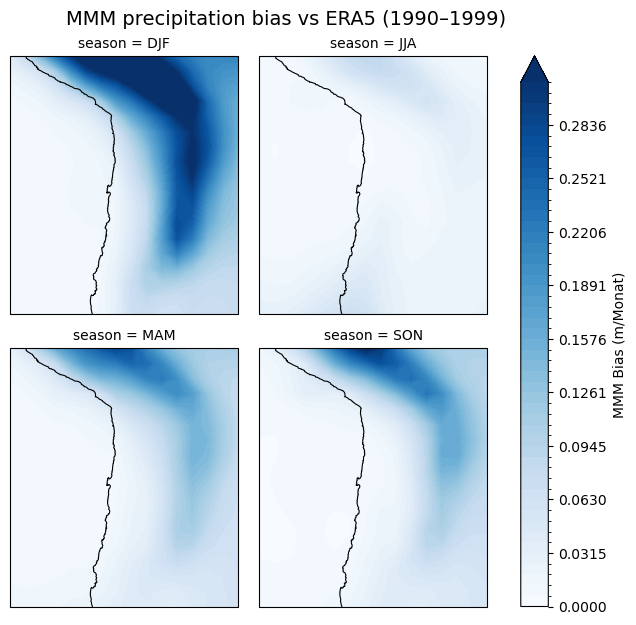

In [30]:

bias_stack = xr.concat(list(model_bias_season.values()), dim="model")

bias_stack = bias_stack.assign_coords(model=("model", list(model_bias_season.keys())))

mmm_bias_season = bias_stack.mean("model")


A = float(np.nanquantile(np.abs(mmm_bias_season.values), 0.98))
levels = np.linspace(0, A, 50)

g = mmm_bias_season.plot.contourf(
    col="season", col_wrap=2,
    subplot_kws={"projection": ccrs.PlateCarree()},
    transform=ccrs.PlateCarree(),
    cmap="Blues", 
    levels=levels,
    cbar_kwargs={"label": "MMM Bias (m/Monat)"})
g.fig.suptitle("MMM precipitation bias vs ERA5 (1990–1999)", y=1.02, fontsize=14)
for ax in g.axes.flat:
    ax.coastlines(linewidth=0.8, zorder=10)
    

In [31]:
#Error processing model CMIP.MPI-M.ICON-ESM-LR.historical.Amon.gn: "no index found for coordinate 'lat'"
#Das Modell MPI-M.ICON-ESM-LR hat kein lat/lon Koordinaten und wurde deshalb rausgehauen 
model_biases = {}
for name, regridded_data in regridded_dset.items():
    # Berechne Bias
    bias = regridded_data - area_prec2
    model_biases[name] = bias

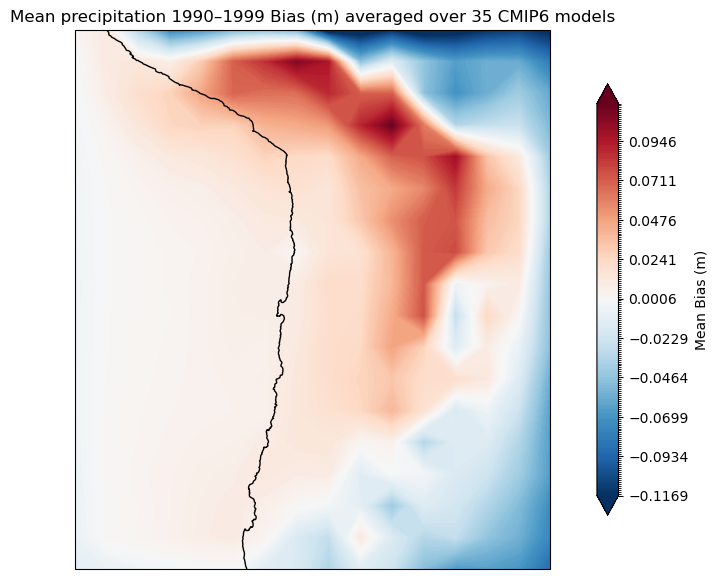

In [32]:
bias_stack = xr.concat(model_biases.values(), dim="model")
bias_stack = bias_stack.assign_coords(model=("model", list(model_biases.keys())))
bias_mean = bias_stack.mean(dim="model")
A = float(np.nanquantile(np.abs(bias_mean.values), 0.98))  # ggf. 0.95 für mehr Kontrast
levels = np.linspace(-A, A, 200)
plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())   # Daten sind in PlateCarree
im = bias_mean.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap="RdBu_r",                               # sequentiell statt divergend
    levels=levels,
    extend='both',
    cbar_kwargs={"label": "Mean Bias (m)", "shrink": 0.8}
)
ax.coastlines()
ax.set_title(f"Mean precipitation 1990–1999 Bias (m) averaged over {len(model_biases)} CMIP6 models")
plt.show()

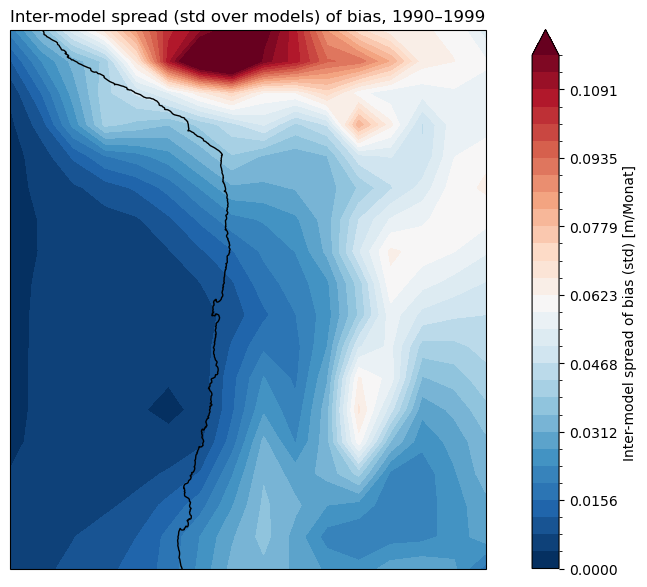

In [42]:
bias_spread = bias_stack.std("model")   # (lat, lon)
A = float(np.nanquantile(np.abs(bias_mean.values), 0.98))
levels = np.linspace(0, A, 31)

plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
#relative_bias_spread = (bias_spread / area_prec2) * 100



bias_spread.plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    levels=levels,
    extend="max",
    cbar_kwargs={"label": "Inter-model spread of bias (std) [m/Monat]"}
)

ax.coastlines()
ax.set_title("Inter-model spread (std over models) of bias, 1990–1999")
plt.show()

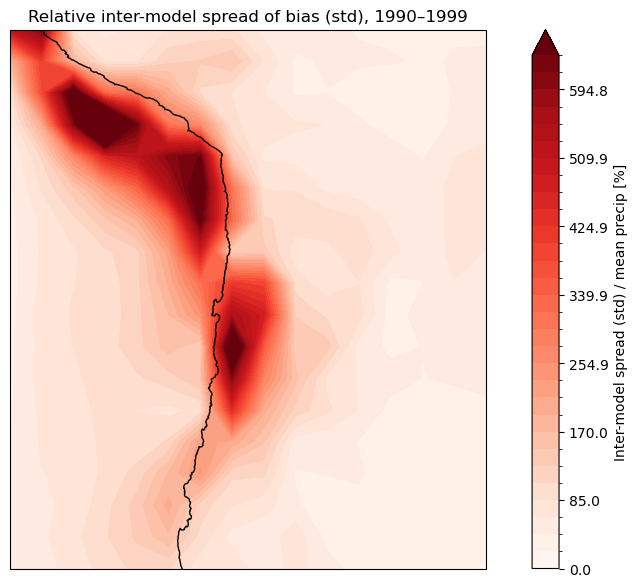

In [40]:
bias_spread = bias_stack.std("model")   # [m/Monat]

# --- Denominator wählen ---
# Option A (empfohlen): CMIP MMM Precip (nicht Bias!)
# mmm_pr = pr_stack.mean("model")        # falls du pr_stack hast
# den = mmm_pr

# Option B: ERA5 Mean Precip (wenn du mmm_pr nicht hast)
den = area_prec2   # <-- dein ERA5 mean precip Feld (m/Monat), gleiche Region/Grid

den = xr.where(np.abs(den) > 1e-6, np.abs(den), np.nan)
relative_spread = 100 * bias_spread / den   # [%]

# --- levels in % ---
A = float(np.nanquantile(relative_spread.values, 0.98))
levels = np.linspace(0, A, 31)

plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

relative_spread.plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Reds",
    levels=levels,
    extend="max",
    cbar_kwargs={"label": "Inter-model spread (std) / mean precip [%]"},
)

ax.coastlines()
ax.set_title("Relative inter-model spread of bias (std), 1990–1999")
plt.show()

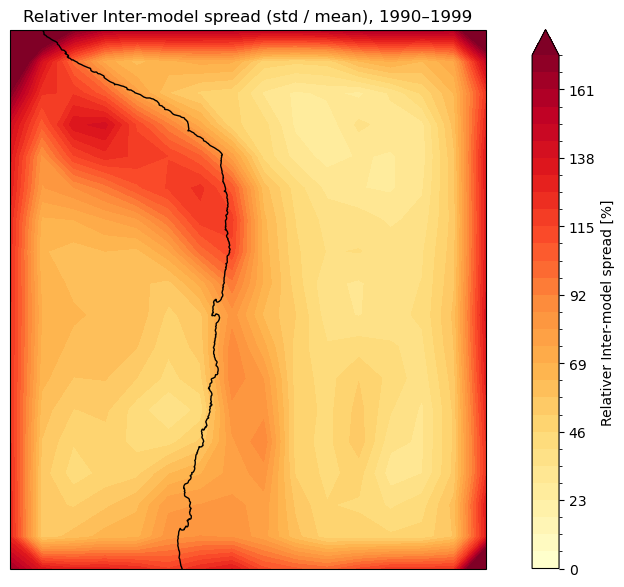

In [50]:
# 1. Berechne den absoluten Mittelwert über alle 35 CMIP6-Modelle
model_mean_absolute = bias_stack.mean("model") + area_prec2

# 2. Berechne den relativen Spread (Variationskoeffizient) in Prozent
# Wir teilen die Standardabweichung (Spread) durch den absoluten Mittelwert
relative_spread = (bias_spread / model_mean_absolute) * 100

# 3. Visualisierung
plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Dynamische Skalierung für die Prozente (z.B. bis zum 98. Perzentil)
A_rel = float(np.nanquantile(relative_spread.values, 0.95))
levels_rel = np.linspace(0, A_rel, 31)

relative_spread.plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="YlOrRd", 
    levels=levels_rel,
    extend="max",
    cbar_kwargs={"label": "Relativer Inter-model spread [%]"}
)

ax.coastlines()
ax.set_title("Relativer Inter-model spread (std / mean), 1990–1999")
plt.show()